# Deep Knowledge Tracing using Transformer model

Dataset: Assistments 2017

# Data Layer

Import Dataset from Drive

In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

assistments = pd.read_csv('/content/drive/MyDrive/DeepKT/assistments_2017.csv')

Mounted at /content/drive


<ipython-input-1-fc93e142744a>:6: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  assistments = pd.read_csv('/content/drive/MyDrive/DeepKT/assistments_2017.csv')


**Assistments 2017**

We will use mainly 2 columns from the dataframe: Skill and Correctness, the other two columns will be for aiding preprocessing.

In [5]:
assistments[['studentId', 'skill', 'correct', 'action_num']].head(15000)

assistments['action_num'].nunique()



942816

# Preprocess

In [ ]:
import pandas as pd
import numpy as np

from dataclasses import dataclass
from typing import Tuple, List, Dict

@dataclass
class SequenceConfig:
  seq_length: int
  sliding_window_step: int = 1
  max_students: int = 500

class SequenceGenerator:
  def __init__(self, config: SequenceConfig, skill_to_id: Dict):
    self.config = config # Configuring the parameters for preprocessing
    self.skill_to_id = {} # Mapping skills to unique IDs

  def load_and_process(self, file_path: str) -> Tuple[pd.DataFrame, int]:
    # Load and preprocess data from Dataset
    data = pd.read_csv(file_path)

    num_skills = data['skill'].nunique()

    data.sort_values(by=['studentId', 'action_num'])

    selected_students = data['studentId'].unique()[:self.config.max_students]
    data = data[data['studentId'].isin(selected_students)]

    self.skill_to_id = self.skill_map(data)

    return data, num_skills

  def skill_map(self, data: pd.DataFrame) -> Dict[str, int]:
    skill_to_id = {}

    for skill in data['skill'].unique():
      skill_to_id[skill] = len(skill_to_id)

    return skill_to_id

  def encode_interaction(self, skill: int, correctness: int) -> int:
    # Encode each possible interaction uniquely as a number
    return 2 * skill + correctness

  def generate_label(self, num_skills: int, skill: int, correctness: int) -> List[int]:
    # Create labels to calculate BCE loss
    label = np.zeros(num_skills)
    label[skill] = correctness
    return label

  def prepare_student_sequences(self, student_data: pd.DataFrame, num_skills: int) -> Tuple[List, List]:
    # Prepare sequences for each student
    sequences = []
    labels = []

    print('Checkpoint', student_data['studentId'])

    if len(student_data) < self.config.seq_length:
      return sequences, labels

    for i in range(0, len(student_data) - self.config.seq_length, self.config.sliding_window_step):
      if i + self.config.seq_length > len(student_data):
        break

      window = student_data.iloc[i: i + self.config.seq_length]

      next_interaction = student_data.iloc[i + self.config.seq_length]

      encoded_sequence = [self.encode_interaction(self.skill_to_id[row['skill']], row['correct']) for _, row in window.iterrows()]

      sequences.append(encoded_sequence)

      labels.append(window['correct'].tolist())

    return sequences, labels

  def prepare_sequences(self, df: pd.DataFrame, num_skills: int) -> Tuple[List, List]:
    all_sequences = []
    all_labels = []

    for student_id in df['studentId'].unique():
      student_data = df[df['studentId'] == student_id]

      student_seq, student_lab = self.prepare_student_sequences(student_data, num_skills)

      all_sequences.extend(student_seq)
      all_labels.extend(student_lab)

    return all_sequences, all_labels

gen = SequenceGenerator(SequenceConfig(30, 1, 120), {})

df, num_skills = gen.load_and_process('/content/drive/MyDrive/DeepKT/assistments_2017.csv')

df.head(100)

seq, lab = gen.prepare_sequences(df, num_skills)


<ipython-input-25-1ad270b9af39>:20: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Checkpoint 0       8
1       8
2       8
3       8
4       8
       ..
1051    8
1052    8
1053    8
1054    8
1055    8
Name: studentId, Length: 1056, dtype: int64
Checkpoint 1056    35
1057    35
1058    35
1059    35
1060    35
        ..
2044    35
2045    35
2046    35
2047    35
2048    35
Name: studentId, Length: 993, dtype: int64
Checkpoint 2049    39
2050    39
2051    39
2052    39
2053    39
        ..
2462    39
2463    39
2464    39
2465    39
2466    39
Name: studentId, Length: 418, dtype: int64
Checkpoint 2467    64
2468    64
2469    64
2470    64
2471    64
        ..
3881    64
3882    64
3883    64
3884    64
3885    64
Name: studentId, Length: 1419, dtype: int64
Checkpoint 3886    77
3887    77
3888    77
3889    77
3890    77
        ..
4198    77
4199    77
4200    77
4201    77
4202    77
Name: studentId, Length: 317, dtype: int64
Checkpoint 4203    126
4204    126
4205    126
4206    126
4207    126
       ... 
4604    126
4605    126
4606    126
4607    126
460

# **Save and Load Functions**

In [ ]:
import pickle
import json
import os

def save_preprocessed_data(sequences, labels, skill_to_id, config, save_dir='/content/drive/MyDrive/DeepKT/preprocessed_data'):
    """Save preprocessed data to Google Drive"""
    # Mount Google Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    os.makedirs(save_dir, exist_ok=True)

    # Save sequences and labels
    np.save(os.path.join(save_dir, 'sequences_30.npy'), np.array(sequences))
    np.save(os.path.join(save_dir, 'labels_30.npy'), np.array(labels))

    # Save skill mapping and configuration
    metadata = {
        'skill_to_id': skill_to_id,
        'config': {
            'seq_length': config.seq_length,
            'sliding_window_step': config.sliding_window_step,
            'num_students': config.max_students
        },
        'dataset_stats': {
            'num_sequences': len(sequences),
            'sequence_length': len(sequences[0]) if sequences else 0,
            'num_skills': len(skill_to_id)
        }
    }

    with open(os.path.join(save_dir, 'metadata_30.json'), 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Data saved successfully to {save_dir}")
    print("Files saved:")
    print(f"- sequences_30.npy: {os.path.getsize(os.path.join(save_dir, 'sequences_30.npy'))/1024/1024:.2f} MB")
    print(f"- labels_30.npy: {os.path.getsize(os.path.join(save_dir, 'labels_30.npy'))/1024/1024:.2f} MB")
    print(f"- metadata_30.json: {os.path.getsize(os.path.join(save_dir, 'metadata_30.json'))/1024:.2f} KB")

# # Save Preprocessed Data:
save_preprocessed_data(seq, lab, gen.skill_to_id, gen.config)

Data saved successfully to /content/drive/MyDrive/DeepKT/preprocessed_data
Files saved:
- sequences_30.npy: 21.70 MB
- labels_30.npy: 21.70 MB
- metadata_30.json: 2.85 KB


# **In case already preprocessed, load initial packages and start here**

In [ ]:
import pickle
import json
import os
from google.colab import drive
import numpy as np

def load_preprocessed_data(load_dir='/content/drive/MyDrive/DeepKT/preprocessed_data'):
    """Load preprocessed data from Google Drive"""
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Load sequences and labels
    sequences = np.load(os.path.join(load_dir, 'sequences_30.npy'))
    labels = np.load(os.path.join(load_dir, 'labels_30.npy'))

    # Load metadata
    with open(os.path.join(load_dir, 'metadata_30.json'), 'r') as f:
        metadata = json.load(f)

    print("Data loaded successfully")
    print(f"Loaded {metadata['dataset_stats']['num_sequences']} sequences")
    print(f"Sequence length: {metadata['dataset_stats']['sequence_length']}")
    print(f"Number of skills: {metadata['dataset_stats']['num_skills']}")

    return sequences, labels, metadata

# Load in preprocessed data
sequences, labels, metadata = load_preprocessed_data()

print(sequences[:50])
print(labels[:50])

Data loaded successfully
Loaded 94810 sequences
Sequence length: 30
Number of skills: 90
[[ 0  1  2 ... 11 11 14]
 [ 1  2  2 ... 11 14 14]
 [ 2  2  3 ... 14 14 15]
 ...
 [10 23 13 ... 35 35 37]
 [23 13 11 ... 35 37 37]
 [13 11 10 ... 37 37 37]]
[[0 1 0 ... 1 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [0 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]]


# Data Transformation

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(sequences, labels, batch_size = 64, train_ratio = 0.7, val_ratio = 0.15):
  sequences = sequences.astype(np.int32)
  labels = labels.astype(np.float32)

  train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(sequences, labels, train_size=train_ratio, random_state=42)

  val_ratio_adjusted = val_ratio / (1 - train_ratio)

  val_sequences, test_sequences, val_labels, test_labels = train_test_split(temp_sequences, temp_labels, train_size=val_ratio_adjusted, random_state=42)

  def create_dataset(sequences, labels, batch_size, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((sequences, labels))

    if training:
      dataset = dataset.shuffle(len(sequences)) # Shuffle tensors

    dataset = dataset.batch(batch_size)

    if training:
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # Prefetch for optimum training

    return dataset

  train_dataset = create_dataset(train_sequences, train_labels, batch_size)
  val_dataset = create_dataset(val_sequences, val_labels, batch_size)
  test_dataset = create_dataset(test_sequences, test_labels, batch_size)

  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = prepare_data(sequences, labels)

def inspect_dataset(dataset, name="Dataset"):
    """Helper function to inspect the prepared datasets"""
    for sequences, labels in dataset.take(1):
        print(f"\n{name} inspection:")
        print(f"Sequences shape: {sequences.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Sequences dtype: {sequences.dtype}")
        print(f"Labels dtype: {labels.dtype}")
        print("\nSample sequence (first in batch):")
        print("Encoded interactions:", sequences[0])
        print("Correctness labels:", labels[0])

inspect_dataset(train_dataset, "Training")
inspect_dataset(val_dataset, "Validation")
inspect_dataset(test_dataset, "Test")


Training inspection:
Sequences shape: (64, 30)
Labels shape: (64, 30)
Sequences dtype: <dtype: 'int32'>
Labels dtype: <dtype: 'float32'>

Sample sequence (first in batch):
Encoded interactions: tf.Tensor(
[15 14 14 15 15 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15
 14 15 15 68 69 54], shape=(30,), dtype=int32)
Correctness labels: tf.Tensor(
[1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0.], shape=(30,), dtype=float32)

Validation inspection:
Sequences shape: (64, 30)
Labels shape: (64, 30)
Sequences dtype: <dtype: 'int32'>
Labels dtype: <dtype: 'float32'>

Sample sequence (first in batch):
Encoded interactions: tf.Tensor(
[117 117 117 117 117 117 116 117 117 116 116 116 154 154 154 155 155 155
 116 116 116 117  54 116 116 116 117 116 116 116], shape=(30,), dtype=int32)
Correctness labels: tf.Tensor(
[1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0.], shape=(30,), dtype=float32)

Test insp

# Transformer Implementation

In [ ]:
import tensorflow as tf
import time
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, MultiHeadAttention, LayerNormalization, Embedding

# ================================================
# Transformer Block with Causal Masking
# ================================================
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask):
        # Pass the mask to the attention layer.
        attn_output = self.att(inputs, inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ================================================
# Transformer Model
# ================================================
class TransformerModel(tf.keras.Model):
    def __init__(self, num_items, seq_len, embed_dim, num_heads, ff_dim, num_blocks, mlp_units, dropout_rate=0.1):
        """
        Args:
          num_items: Size of the vocabulary.
          seq_len: Length of the sequences.
          embed_dim: Embedding dimension.
          num_heads: Number of attention heads.
          ff_dim: Feed-forward network hidden layer size.
          num_blocks: Number of transformer blocks.
          mlp_units: List with the number of units for each MLP Dense layer.
          dropout_rate: Dropout rate.
        """
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.embedding = Embedding(num_items, embed_dim)
        # Positional encoding as an Embedding layer.
        self.pos_encoding = Embedding(seq_len, embed_dim)
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_blocks)
        ]
        self.mlp_layers = [Dense(mlp_dim, activation="relu") for mlp_dim in mlp_units]
        self.dropout = Dropout(dropout_rate)
        self.final_layer = Dense(1)  # No activation here; we apply sigmoid later.

    def causal_attention_mask(self, batch_size, seq_len):
        """
        Create a boolean causal mask of shape (batch_size, seq_len, seq_len)
        where True indicates allowed (i.e. non-masked) positions.
        """
        # Create a lower-triangular matrix of ones.
        lower_triangle = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        # Cast to boolean: True means allowed.
        mask = tf.cast(lower_triangle, dtype=tf.bool)
        # Tile for each sample in the batch.
        mask = tf.tile(tf.expand_dims(mask, 0), [batch_size, 1, 1])
        return mask

    def call(self, inputs, training):
        """
        Args:
          inputs: Tensor of shape (batch_size, seq_len) of token IDs.
          training: Boolean, for dropout behavior.
        Returns:
          predictions: Tensor of shape (batch_size, seq_len) with values in [0,1].
        """
        batch_size = tf.shape(inputs)[0]
        # Create positional indices.
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        positions = tf.expand_dims(positions, 0)           # (1, seq_len)
        positions = tf.tile(positions, [batch_size, 1])      # (batch_size, seq_len)

        x = self.embedding(inputs)         # (batch_size, seq_len, embed_dim)
        pos_enc = self.pos_encoding(positions)
        x = x + pos_enc

        # Create the causal mask.
        mask = self.causal_attention_mask(batch_size, self.seq_len)  # (batch_size, seq_len, seq_len)

        # Pass through transformer blocks.
        for block in self.transformer_blocks:
            x = block(x, training=training, mask=mask)

        # Pass through the MLP layers.
        for layer in self.mlp_layers:
            x = layer(x)
            x = self.dropout(x, training=training)

        x = self.final_layer(x)  # (batch_size, seq_len, 1)
        x = tf.sigmoid(x)        # Map outputs to [0, 1]
        return tf.squeeze(x, -1) # (batch_size, seq_len)

# Model Training

In [ ]:
# ================================================
# Training, Evaluation, and Testing
# ================================================
@tf.function
def train_step(model, optimizer, batch_sequences, batch_labels):
    """
    Performs one training step.
    For knowledge tracing, we predict the outcome at time t+1.
    """
    with tf.GradientTape() as tape:
        predictions = model(batch_sequences, training=True)
        # Shift predictions and labels so that prediction at time t is compared with label at time t+1.
        pred = predictions[:, :-1]
        target = tf.cast(batch_labels[:, 1:], tf.float32)
        loss = tf.keras.losses.binary_crossentropy(target, pred)
        loss = tf.reduce_mean(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def evaluate_model(model, dataset):
    """
    Evaluate the model on the given dataset.
    Returns:
      auc: ROC-AUC score.
      accuracy: Binary accuracy.
    """
    all_preds = []
    all_labels = []
    for batch_sequences, batch_labels in dataset:
        predictions = model(batch_sequences, training=False)
        pred = predictions[:, :-1]
        target = batch_labels[:, 1:]
        all_preds.append(pred)
        all_labels.append(target)
    all_preds = tf.concat(all_preds, axis=0)
    all_labels = tf.concat(all_labels, axis=0)
    # Flatten the tensors.
    all_preds_np = all_preds.numpy().flatten()
    all_labels_np = all_labels.numpy().flatten()
    try:
        auc = roc_auc_score(all_labels_np, all_preds_np)
    except Exception as e:
        print("Error computing AUC:", e)
        auc = 0.0
    y_pred_bin = (all_preds_np > 0.5).astype(int)
    accuracy = accuracy_score(all_labels_np, y_pred_bin)
    return auc, accuracy

def train_model(model, train_dataset, val_dataset, test_dataset, epochs=50, patience=10, learning_rate=0.001):
    """
    Train the Transformer model while evaluating on training, validation, and test sets.
    Early stopping is applied based on validation AUC.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    best_test_auc = 0.0
    patience_counter = 0
    best_weights = None

    for epoch in range(epochs):
        start_time = time.time()
        train_loss_metric = tf.keras.metrics.Mean()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training loop
        for batch_idx, (batch_sequences, batch_labels) in enumerate(train_dataset):
            loss = train_step(model, optimizer, batch_sequences, batch_labels)
            train_loss_metric.update_state(loss)
            if (batch_idx + 1) % 50 == 0:
                print(f"  Batch {batch_idx+1} - Loss: {loss:.4f}")

        epoch_loss = train_loss_metric.result().numpy()
        print(f"Epoch {epoch+1} - Average Training Loss: {epoch_loss:.4f}")

        # train_auc, train_accuracy = evaluate_model(model, train_dataset)
        # val_auc, val_accuracy = evaluate_model(model, val_dataset)
        test_auc, test_accuracy = evaluate_model(model, test_dataset)

        # print(f"  Training Metrics - AUC: {train_auc:.4f} | Accuracy: {train_accuracy:.4f}")
        # print(f"  Validation Metrics - AUC: {val_auc:.4f} | Accuracy: {val_accuracy:.4f}")
        print(f"  Test Metrics - AUC: {test_auc:.4f} | Accuracy: {test_accuracy:.4f}")

        # Early stopping based on validation AUC.
        if test_auc > best_test_auc:
            best_test_auc = test_auc
            best_weights = model.get_weights()
            patience_counter = 0
            print("  New best model found!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  Early stopping triggered!")
                break

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1} took {epoch_time:.2f}s")

    if best_weights is not None:
        model.set_weights(best_weights)
        print(f"\nTraining completed. Best Validation AUC: {best_test_auc:.4f}")

    final_test_auc, final_test_accuracy = evaluate_model(model, test_dataset)
    print(f"\nFinal Test Metrics - AUC: {final_test_auc:.4f} | Accuracy: {final_test_accuracy:.4f}")
    return model

model = TransformerModel(
    num_items=2 * len(metadata['skill_to_id']),
    seq_len=metadata['config']['seq_length'],
    embed_dim=64,
    num_heads=4,
    ff_dim=64,
    num_blocks=4,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

trained_model = train_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=50,
    patience=10,
    learning_rate=0.001
)


Epoch 1/50
  Batch 50 - Loss: 0.6223
  Batch 100 - Loss: 0.6222
  Batch 150 - Loss: 0.6363
  Batch 200 - Loss: 0.6044
  Batch 250 - Loss: 0.6126
  Batch 300 - Loss: 0.6095
  Batch 350 - Loss: 0.6223
  Batch 400 - Loss: 0.6124
  Batch 450 - Loss: 0.6185
  Batch 500 - Loss: 0.6254
  Batch 550 - Loss: 0.6018
  Batch 600 - Loss: 0.6026
  Batch 650 - Loss: 0.6125
  Batch 700 - Loss: 0.6144
  Batch 750 - Loss: 0.5880
  Batch 800 - Loss: 0.6211
  Batch 850 - Loss: 0.5957
  Batch 900 - Loss: 0.6128
  Batch 950 - Loss: 0.6300
  Batch 1000 - Loss: 0.5884
Epoch 1 - Average Training Loss: 0.6109
  Test Metrics - AUC: 0.6776 | Accuracy: 0.6878
  New best model found!
Epoch 1 took 50.81s

Epoch 2/50
  Batch 50 - Loss: 0.5956
  Batch 100 - Loss: 0.5953
  Batch 150 - Loss: 0.6084
  Batch 200 - Loss: 0.5850
  Batch 250 - Loss: 0.5905
  Batch 300 - Loss: 0.5815
  Batch 350 - Loss: 0.6069
  Batch 400 - Loss: 0.5930
  Batch 450 - Loss: 0.5958
  Batch 500 - Loss: 0.5908
  Batch 550 - Loss: 0.5729
  Batch 

# Save Model

In [ ]:
save_dir = "/content/drive/MyDrive/DeepKT/saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_save_path = os.path.join(save_dir, "seq30_trained_model.weights.h5")
trained_model.save_weights(model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /content/drive/MyDrive/DeepKT/saved_models/seq20_trained_model.weights.h5


# Load Model

In [ ]:
# ====================================================
# Load the model for evaluation & visualization
# ====================================================
# Recreate the model architecture with the same configuration.

model_save_path = "/content/drive/MyDrive/DeepKT/saved_models/seq60_trained_model.weights.h5"

loaded_model = TransformerModel(
    num_items=2 * len(metadata['skill_to_id']),
    seq_len=metadata['config']['seq_length'],
    embed_dim=64,
    num_heads=4,
    ff_dim=64,
    num_blocks=4,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Build the model by passing a dummy input.
dummy_input = tf.zeros((1, metadata['config']['seq_length']))
_ = loaded_model(dummy_input, training=False)

# Load the saved weights.
loaded_model.load_weights(model_save_path)
print(f"Model loaded from {model_save_path}")


Model loaded from /content/drive/MyDrive/DeepKT/saved_models/seq60_trained_model.weights.h5


# Visualization

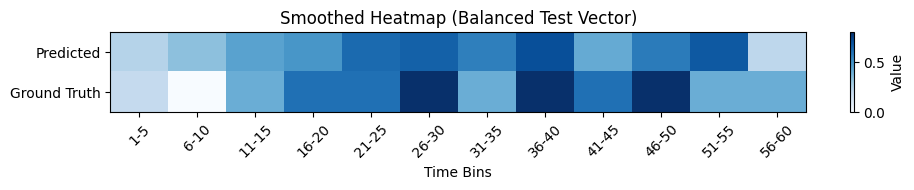

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, dataset):
    """
    Generate and display the ROC curve for the given dataset.

    This function iterates over the dataset, collects the model predictions
    (after shifting to align with t+1) and true labels, computes the false
    positive and true positive rates, and then plots the ROC curve along with
    the computed AUC.
    """
    all_preds = []
    all_labels = []
    for batch_sequences, batch_labels in dataset:
        predictions = model(batch_sequences, training=False)
        # Align predictions with labels by removing the final timestep.
        pred = predictions[:, :-1]
        target = batch_labels[:, 1:]
        all_preds.append(pred)
        all_labels.append(target)

    # Concatenate predictions and labels from all batches.
    all_preds = tf.concat(all_preds, axis=0)
    all_labels = tf.concat(all_labels, axis=0)
    y_scores = all_preds.numpy().flatten()
    y_true = all_labels.numpy().flatten()

    # Compute ROC curve and AUC.
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve.
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", lw=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # assuming tensorflow is used as in your original code

def visualize_sample_heatmap_gradient_balanced(model, dataset, bin_size=5):
    """
    Visualize a single sample's performance over time as a smoothed heatmap
    with a gradient of blue shades. Instead of specifying a sample index, this
    function selects the sample with ground truth values closest to a 50-50
    split of correct (1) and incorrect (0) responses.

    The function:
      1. Retrieves one batch from the dataset.
      2. Iterates through the batch to choose the sample whose ground truth is most balanced.
      3. Computes model predictions (assumed shape: (batch_size, seq_len)).
      4. Aggregates predictions and ground truth values into bins (of length bin_size).
      5. Constructs a heatmap with two rows:
         - Row 0: Average predicted probability per bin.
         - Row 1: Average ground truth per bin.

    Args:
      model: The trained model that outputs predictions with shape (batch_size, seq_len).
      dataset: A tf.data.Dataset yielding (batch_sequences, batch_labels).
      bin_size: Number of time steps to aggregate into each bin.
    """
    # Retrieve one batch from the dataset.
    for batch_sequences, batch_labels in dataset.take(1):
        break

    # Convert tensors to NumPy arrays.
    batch_sequences_np = batch_sequences.numpy()
    batch_labels_np = batch_labels.numpy()

    # Loop to choose the balanced test vector:
    balanced_index = None
    min_diff = float('inf')
    for i in range(batch_labels_np.shape[0]):
        # Compute the average correctness for sample i.
        avg_correct = np.mean(batch_labels_np[i])
        # Compute the difference from the balanced ratio of 0.5.
        diff = abs(avg_correct - 0.5)
        if diff < min_diff:
            min_diff = diff
            balanced_index = i

    # Use the balanced sample.
    sample_index = balanced_index

    # Select the sample sequence and corresponding ground truth.
    sample_sequence = batch_sequences_np[sample_index:sample_index+1]
    sample_labels = batch_labels_np[sample_index]  # shape: (seq_len,)

    # Obtain model predictions. Expected shape: (1, seq_len)
    predictions = model(sample_sequence, training=False).numpy()
    pred_probs = predictions[0]  # shape: (seq_len,)

    seq_len = len(pred_probs)
    num_bins = int(np.ceil(seq_len / bin_size))
    avg_pred = []
    avg_true = []
    for i in range(num_bins):
        start = i * bin_size
        end = min((i + 1) * bin_size, seq_len)
        avg_pred.append(np.mean(pred_probs[start:end]))
        avg_true.append(np.mean(sample_labels[start:end]))

    # Stack the aggregated values into a 2D array:
    # Row 0: Average predicted probabilities, Row 1: Average ground truth.
    heatmap_data = np.vstack([avg_pred, avg_true])

    # Plot the heatmap with a lower vertical height.
    fig, ax = plt.subplots(figsize=(10, 2))
    cax = ax.imshow(heatmap_data, aspect='auto', cmap='Blues', origin='upper', interpolation='nearest')
    fig.colorbar(cax, ax=ax, label='Value')

    # Set y-axis labels.
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Avg Predicted', 'Avg Ground Truth'])
    # Set x-axis ticks and labels for each bin.
    ax.set_xticks(np.arange(num_bins))
    x_labels = [f"{i*bin_size+1}-{min((i+1)*bin_size, seq_len)}" for i in range(num_bins)]
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_xlabel("Time Bins")
    ax.set_title("Smoothed Heatmap (Balanced Test Vector)")
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_sample_heatmap_gradient_balanced(loaded_model, test_dataset, bin_size=5)

# plot_roc_curve(loaded_model, test_dataset)

